# **Home Credit Scorecard Model**

**About:** 

Many individuals face difficulties in obtaining loans due to lack of or no credit history. Home Credit seeks to expand access to finance for the unbanked by providing a positive and secure lending experience. The goal is to ensure that these underserved individuals have a good lending experience. Home Credit uses a variety of alternative data to predict customers' repayment ability. By doing this, Home Credit ensures that individuals who are able to repay are not turned away and loans are made with principles, terms and repayment schedules that promote customer success.

**Objective**

Create a Machine Learning Model that can provide suitability scores to clients in obtaining loans.


**Actions**

Predicting a customer's ability to repay a loan using the TARGET variable. The main evaluation focus is on F1-score to reduce prediction errors (false positive and false negative). Prediction is based on the customer's ability to repay (0: Able, 1: Unable).

**Tested Model :**
1. KNN (K-Nearest Neighbors)
2. Desicion Tree
3. Naive Bayes 
   - Naive Bayes without oversampling
   - Naive Bayes oversampling

**Library Used**

In [326]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [327]:
import warnings
warnings.simplefilter(action='ignore')

In [328]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


In [329]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


In [330]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

In [331]:
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import (recall_score,
                            precision_score,
                            f1_score,
                            classification_report,
                            roc_auc_score)

## **Data Import**

In [332]:
data_train = pd.read_csv('datanih/application_train.csv')

## Function **Definition**

In [333]:
def dataInfo(data) :
    pd.set_option('display.max_rows',None)
    missing_values = data.isnull().sum()
    missing_perc = (missing_values/len(data))*100
    data_type = data.dtypes
    num_unique = data.nunique()
    
    print (f'Number of Rows,Columns {data.shape}')
    print (f'Number of Duplicated Values {data.duplicated().sum()}')
    
    return pd.DataFrame ({'Missing_value' : missing_values,
                        'Percent_missing_%' : missing_perc,
                        'Data_type' : data_type,
                        'Number of Unique' : num_unique}).sort_values('Percent_missing_%',ascending=False)

**Outliers Data**

In [334]:
def outlier(df,column) :
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3-q1
    lower = q1 - (1.5*iqr)
    upper = q3 + (1.5*iqr)
    
    outlier_list=df[column].apply(lambda x:'outlier' if x<lower or x>upper else 'not-outlier')
    print (f' outlier lower limit : {lower} \n outlier upper limit : {upper}')
    return outlier_list

**Check Data**

In [335]:
def dataCek (x,y) :
    
    obs_x = pd.crosstab(X_train[x],X_train[y])
    chi2, p, dof, expected = chi2_contingency(obs_x)
    alpha = 0.05

    
    if p<alpha :
        print (f'===== {x} =====')
        print('Number Expected :')
        print(expected)
        print()
        print (f'Chi-square Statistic : {chi2} ,p-value: {p} kurang dari {alpha} \nVariabel 1 dan Variabel 2 adalah variabel dependent')
        print()
        
    else : 
        print (f'===== {x} =====')
        print('Number Expected :')
        print(expected)
        print()
        print (f'Chi-square Statistic : {chi2} ,p-value: {p} lebih dari {alpha} \nVariabel 1 dan Variabel 2 adalah variabel independent')
        print()

def annova_cek (x) :
    churn_yes = X_train[X_train['Churn']==1][x]
    churn_no  = X_train[X_train['Churn']==0][x]

    alpha = 0.05
    ftest,p_value = f_oneway(churn_yes,churn_no)

    if p_value < alpha :
        print(x)
        print(f'Kesimpulan : nilai p_value {p_value} kurang dari alpha {alpha}, nilai ftest = {ftest}')
        print('Terdapat perbedaan target yang signifikan dari segi predictor')
        print()

    else :
        print(x)
        print(f'Kesimpulan : nilai p_value {p_value} lebih dari alpha {alpha}, nilai ftest = {ftest}')
        print('Tidak terdapat perbedaan target yang signifikan dari segi predictor')
        print()

**Evaluation MOdel**

In [336]:
def eval_train (X,y,model) :
    model.fit(X,y)
    prediction = model.predict(X)
    
    cm = confusion_matrix(y,prediction,labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=model.classes_)
    
    print(f' Recall Score : {recall_score(y,prediction)}')
    print(f' Precision Score : {precision_score(y,prediction)}')
    print(f' F1 Score : {f1_score(y,prediction)}')
    print(f' ROC-AUC Score : {roc_auc_score(y,model.predict_proba(X)[:,1])}')
    
    disp.plot()
    
def eval_test (X,y,model) :
    prediction = model.predict(X)
    
    cm = confusion_matrix(y,prediction,labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=model.classes_)
    
    print(f' Recall Score : {recall_score(y,prediction)}')
    print(f' Precision Score : {precision_score(y,prediction)}')
    print(f' F1 Score : {f1_score(y,prediction)}')
    print(f' ROC-AUC Score : {roc_auc_score(y,model.predict_proba(X)[:,1])}')
    
    disp.plot()

In [337]:
data_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [338]:
feature_data = data_train[['SK_ID_CURR',
'NAME_CONTRACT_TYPE',
'CODE_GENDER',
'FLAG_OWN_CAR',
'FLAG_OWN_REALTY',
'CNT_CHILDREN',
'AMT_INCOME_TOTAL',
'AMT_CREDIT',
'DAYS_BIRTH',
'CNT_FAM_MEMBERS',
'REGION_RATING_CLIENT',
'WEEKDAY_APPR_PROCESS_START',
'REG_REGION_NOT_LIVE_REGION',
'TARGET']]

feature_data['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

In [339]:
for x in feature_data.columns : 
    print (f'===== {x} =====')
    print (f'{feature_data[x].unique()}')
    print()

===== SK_ID_CURR =====
[100002 100003 100004 ... 456253 456254 456255]

===== NAME_CONTRACT_TYPE =====
['Cash loans' 'Revolving loans']

===== CODE_GENDER =====
['M' 'F' 'XNA']

===== FLAG_OWN_CAR =====
['N' 'Y']

===== FLAG_OWN_REALTY =====
['Y' 'N']

===== CNT_CHILDREN =====
[ 0  1  2  3  4  7  5  6  8  9 11 12 10 19 14]

===== AMT_INCOME_TOTAL =====
[202500.  270000.   67500.  ...  96768.  546250.5 113062.5]

===== AMT_CREDIT =====
[ 406597.5 1293502.5  135000.  ...  181989.   743863.5 1391130. ]

===== DAYS_BIRTH =====
[ -9461 -16765 -19046 ...  -7951  -7857 -25061]

===== CNT_FAM_MEMBERS =====
[ 1.  2.  3.  4.  5.  6.  9.  7.  8. 10. 13. nan 14. 12. 20. 15. 16. 11.]

===== REGION_RATING_CLIENT =====
[2 1 3]

===== WEEKDAY_APPR_PROCESS_START =====
['WEDNESDAY' 'MONDAY' 'THURSDAY' 'SUNDAY' 'SATURDAY' 'FRIDAY' 'TUESDAY']

===== REG_REGION_NOT_LIVE_REGION =====
[0 1]

===== TARGET =====
[1 0]



## **Data Cleaning**

In [340]:
feature_data.drop(['SK_ID_CURR'], axis = 'columns', inplace = True)
feature_data = feature_data[feature_data['CNT_FAM_MEMBERS'].notna()].reset_index(drop=True)
feature_data = feature_data[~feature_data['CODE_GENDER'].str.contains('XNA')]
feature_data['DAYS_BIRTH'] = feature_data['DAYS_BIRTH'].abs()
feature_data['DAYS_BIRTH'] = (feature_data['DAYS_BIRTH'].div(365).round(0))

dataInfo(feature_data)

Number of Rows,Columns (307505, 13)
Number of Duplicated Values 3215


,Missing_value,Percent_missing_%,Data_type,Number of Unique
NAME_CONTRACT_TYPE,0,0.0,object,2
CODE_GENDER,0,0.0,object,2
FLAG_OWN_CAR,0,0.0,object,2
FLAG_OWN_REALTY,0,0.0,object,2
CNT_CHILDREN,0,0.0,int64,15
AMT_INCOME_TOTAL,0,0.0,float64,2548
AMT_CREDIT,0,0.0,float64,5603
DAYS_BIRTH,0,0.0,float64,49
CNT_FAM_MEMBERS,0,0.0,float64,17
REGION_RATING_CLIENT,0,0.0,int64,3


# **Exploratory Data Analysis (EDA)**

**Data Split**

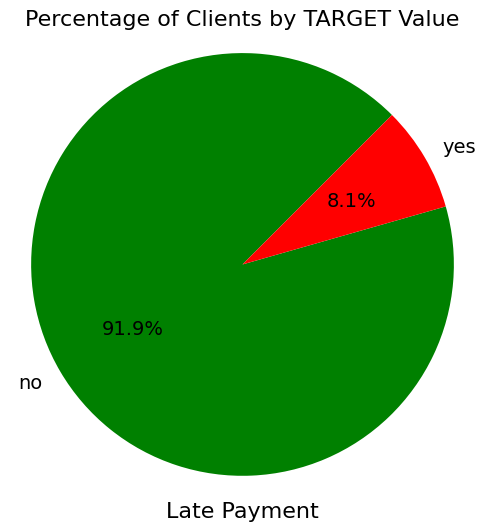

In [341]:
ds = feature_data['TARGET'].value_counts(normalize=True)


plt.figure(figsize=(6,6))

conversion_rate = x.index
count = ds.values
colors= ['green','red']

plt.pie(count, labels=['no','yes'],
        colors=colors, 
        autopct='%1.1f%%',
        startangle=45,
        textprops={'fontsize': 14})

plt.title('Percentage of Clients by TARGET Value',fontsize=16)
plt.xlabel('Late Payment',fontsize=16)
plt.axis('equal')
plt.show()

A total of 91.9% of clients fulfilled their payment obligations, while 8.1% experienced late payments. This means that only about 8% of clients experience late payments. It can be concluded that your business has a low late payment rate. However, it is necessary to regularly monitor the late payment rate to ensure that it remains low.

In [342]:
X = feature_data.drop('TARGET',axis=1).copy()
y = feature_data['TARGET'].copy()

X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.25,random_state=42)

X_train['TARGET'] = y_train
X_test['TARGET'] = y_test

round(((X_train['TARGET'].value_counts(normalize=True))*100),1)

TARGET
0    91.9
1     8.1
Name: proportion, dtype: float64

**Descriptive Statistic**

In [343]:
categoricals = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','WEEKDAY_APPR_PROCESS_START']
numericals = ['CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','DAYS_BIRTH', 'CNT_FAM_MEMBERS','REGION_RATING_CLIENT','REG_REGION_NOT_LIVE_REGION','TARGET']

feature_data[numericals].describe().T


,count,mean,std,min,25%,50%,75%,max
CNT_CHILDREN,307505.0,0.417050,0.722120,0.0,0.0,0.0,1.0,19.0
AMT_INCOME_TOTAL,307505.0,168796.661716,237124.848430,25650.0,112500.0,147150.0,202500.0,117000000.0
AMT_CREDIT,307505.0,599028.395296,402493.886647,45000.0,270000.0,513531.0,808650.0,4050000.0
DAYS_BIRTH,307505.0,43.938798,11.964044,21.0,34.0,43.0,54.0,69.0
CNT_FAM_MEMBERS,307505.0,2.152658,0.910680,1.0,2.0,2.0,3.0,20.0
REGION_RATING_CLIENT,307505.0,2.052461,0.509036,1.0,2.0,2.0,2.0,3.0
REG_REGION_NOT_LIVE_REGION,307505.0,0.015144,0.122128,0.0,0.0,0.0,0.0,1.0
TARGET,307505.0,0.080730,0.272421,0.0,0.0,0.0,0.0,1.0


In [344]:
feature_data[categoricals].describe().T

,count,unique,top,freq
NAME_CONTRACT_TYPE,307505,2,Cash loans,278232
CODE_GENDER,307505,2,F,202447
FLAG_OWN_CAR,307505,2,N,202920
FLAG_OWN_REALTY,307505,2,Y,213306
WEEKDAY_APPR_PROCESS_START,307505,7,TUESDAY,53900


 Most customers who paid late did so within 30 days of the due date. Only about 1% of customers were more than 90 days late.

**Feature Training**

In [345]:
yes_no_dict = {
    'Y':1,
    'N':0 }

for colname in ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    X_train[colname] = X_train[colname].map(yes_no_dict)


weekday_dict = {
    'SUNDAY':1,
    'MONDAY':2,
    'TUESDAY':3,
    'WEDNESDAY':4,
    'THURSDAY':5,
    'FRIDAY':6,
    'SATURDAY':7}
X_train['WEEKDAY_APPR_PROCESS_START'] = X_train['WEEKDAY_APPR_PROCESS_START'].map(weekday_dict)

In [346]:
dataInfo(X_train)

Number of Rows,Columns (230628, 13)
Number of Duplicated Values 1802


,Missing_value,Percent_missing_%,Data_type,Number of Unique
NAME_CONTRACT_TYPE,0,0.0,object,2
CODE_GENDER,0,0.0,object,2
FLAG_OWN_CAR,0,0.0,int64,2
FLAG_OWN_REALTY,0,0.0,int64,2
CNT_CHILDREN,0,0.0,int64,14
AMT_INCOME_TOTAL,0,0.0,float64,2060
AMT_CREDIT,0,0.0,float64,5170
DAYS_BIRTH,0,0.0,float64,49
CNT_FAM_MEMBERS,0,0.0,float64,14
REGION_RATING_CLIENT,0,0.0,int64,3


## **Check Outliners**

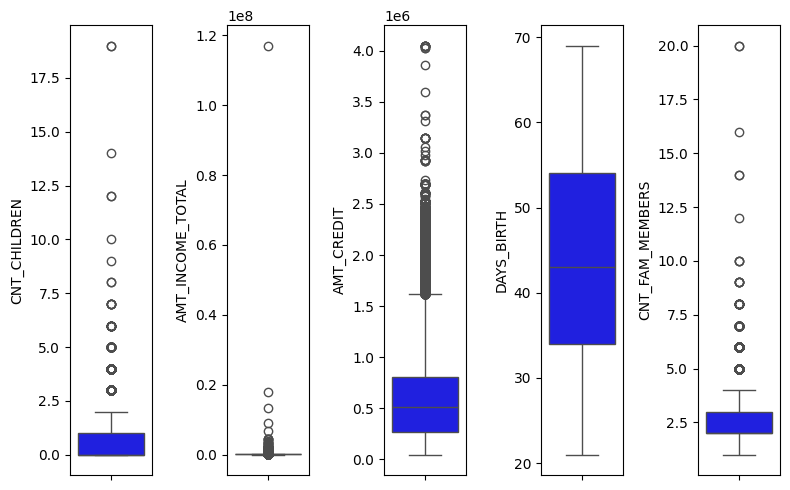

In [347]:
trnasNumericals = ['CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','DAYS_BIRTH', 'CNT_FAM_MEMBERS']

plt.figure(figsize=(8,5))
features = trnasNumericals
for i in range(0, len(features)):
    plt.subplot(1, len(features), i+1)
    sns.boxplot(y=X_train[features[i]], color='blue')
    plt.tight_layout()

In [348]:
X_train_outliers = X_train.copy()

print('CNT_CHILDREN')
outlier(X_train_outliers,'CNT_CHILDREN')
outlier_max = X_train_outliers['CNT_CHILDREN'].max()

print('\nAMT_INCOME_TOTAL')
outlier(X_train_outliers,'AMT_INCOME_TOTAL')
outlier_max = X_train_outliers['AMT_INCOME_TOTAL'].max()

print('\nAMT_CREDIT')
outlier(X_train_outliers,'AMT_CREDIT')
outlier_max = X_train_outliers['AMT_CREDIT'].max()

print('\nCNT_FAM_MEMBERS')
outlier(X_train_outliers,'CNT_FAM_MEMBERS')
outlier_max = X_train_outliers['CNT_FAM_MEMBERS'].max()

CNT_CHILDREN
 outlier lower limit : -1.5 
 outlier upper limit : 2.5

AMT_INCOME_TOTAL
 outlier lower limit : -22500.0 
 outlier upper limit : 337500.0

AMT_CREDIT
 outlier lower limit : -537975.0 
 outlier upper limit : 1616625.0

CNT_FAM_MEMBERS
 outlier lower limit : 0.5 
 outlier upper limit : 4.5


Customers who have more children tend to have a greater possibility of experiencing late payments compared to customers who have fewer children.

In [349]:
X_train = X_train.drop(12840)
y_train = y_train.drop(12840)

**Check the distribution of each column using a KDE (Kernel Density Estimation) plot.**

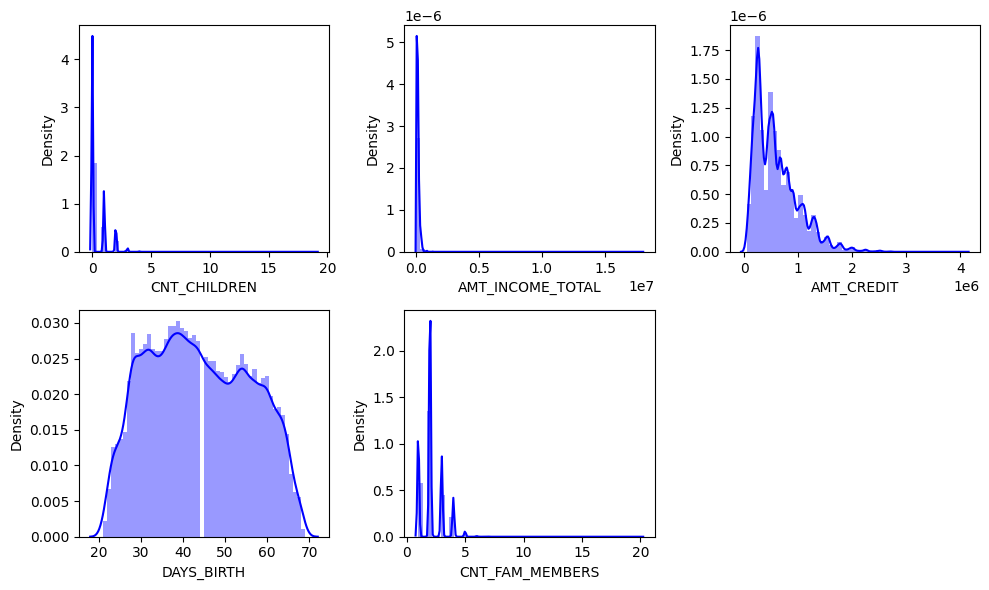

In [350]:
plt.figure(figsize=(10,6))
features = trnasNumericals
for i in range(0, len(features)):
    plt.subplot(2, len(features)//2 + 1, i+1)
    sns.distplot(x=X_train[features[i]], color='blue')
    plt.xlabel(features[i])
    plt.tight_layout()

Gain a better understanding of your customers' children. This can help in making business decisions, such as setting credit policies or developing new products and services.

## **Numericals Column Analysis**

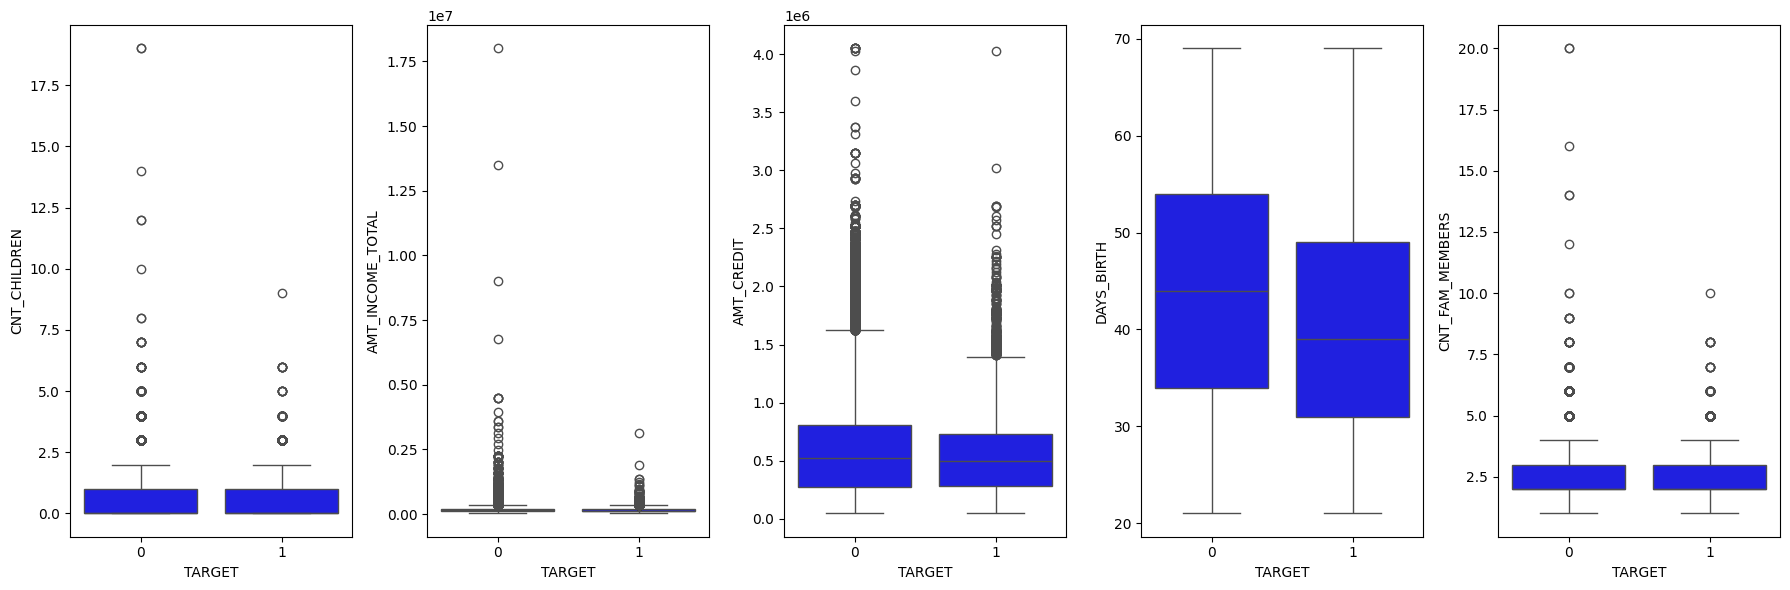

In [351]:
plt.figure(figsize=(18,6))

for x in range(0, len(trnasNumericals)):
    plt.subplot(1, len(trnasNumericals), x+1)
    sns.boxplot(x=X_train['TARGET'],y=X_train[trnasNumericals[x]], color='blue')
    plt.tight_layout()

Some specific observations that can be drawn from this figure:
1. 18-24 year olds have the highest number of children. This could be due to factors such as:
   - Being young and not yet having an established career.
   - May still be in college or not yet working full-time.
   - May not have big financial responsibilities yet.

2. Customers aged 35-44 have the least number of children. This could be due to factors such as:
   - Already have an established career.
   - May have large financial responsibilities, such as a house, car, or children's education costs.
   - May have different views on family.

**Analysis of Customer Demographics**

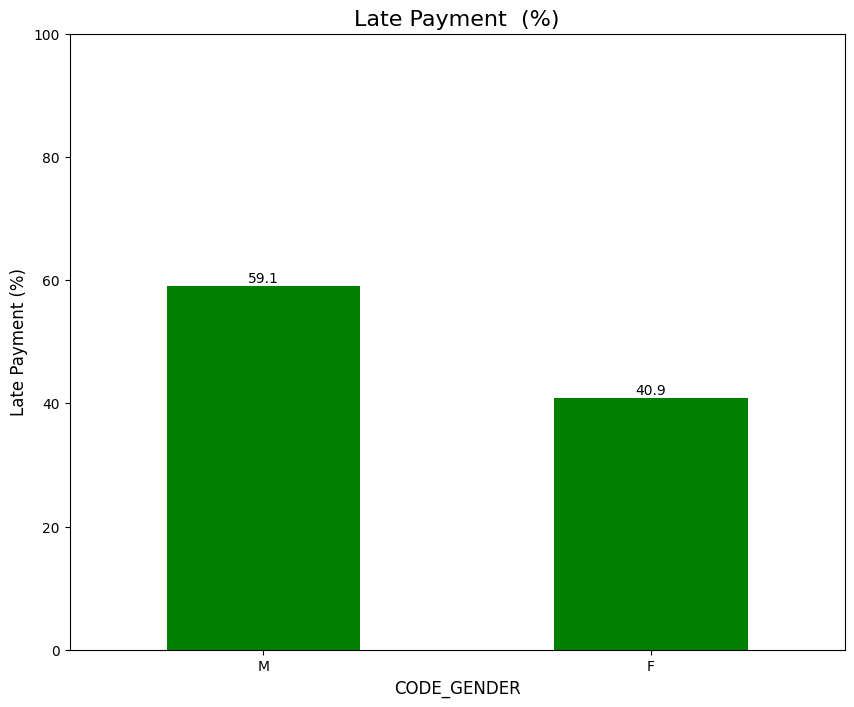

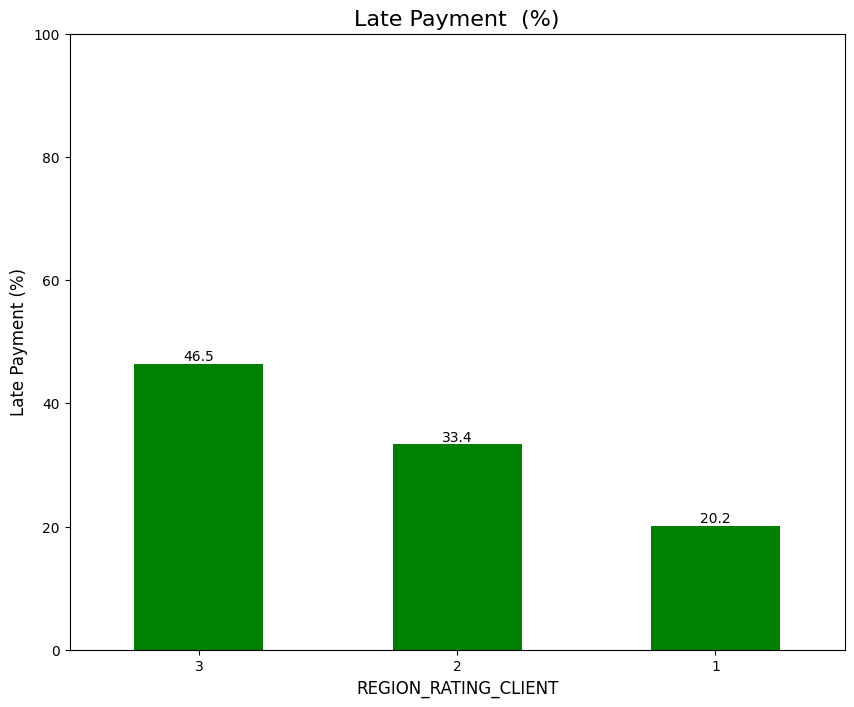

===== CODE_GENDER =====
Number Expected :
[[139652.16234006  12263.83765994]
 [ 72356.83765994   6354.16234006]]

Chi-square Statistic : 678.1578847140188 ,p-value: 1.6808269355791464e-149 kurang dari 0.05 
Variabel 1 dan Variabel 2 adalah variabel dependent

===== REGION_RATING_CLIENT =====
Number Expected :
[[ 22246.388324     1953.611676  ]
 [156367.28956714  13731.71043286]
 [ 33395.32210886   2932.67789114]]

Chi-square Statistic : 783.394428601661 ,p-value: 7.727895705478558e-171 kurang dari 0.05 
Variabel 1 dan Variabel 2 adalah variabel dependent



In [352]:
def predictor_target (p,t='TARGET') :
    
    ax = ((X_train.groupby([p])[t].mean())/((X_train.groupby([p])[t].mean()).sum())*100).sort_values(ascending=False).plot(kind='bar',figsize=(10,8), color='green')
    abs_values = round(((X_train.groupby([p])[t].mean())/((X_train.groupby([p])[t].mean()).sum())*100),1).sort_values(ascending=False)
    ax.bar_label(container=ax.containers[0], labels=abs_values)  
    
    plt.xticks(rotation=0);
    plt.ylabel('Late Payment (%)',fontsize=12)
    plt.title(f'Late Payment  (%)',fontsize=16)
    plt.xlabel(p,fontsize=12)
    plt.ylim(0,100)
    
    plt.show()
    
demographic  = ['CODE_GENDER', 'REGION_RATING_CLIENT']
for x in demographic :
    predictor_target(x)

for x in demographic :
    dataCek(x,'TARGET')


A more detailed explanation of the figure:
1. Chi-square statistic: The value of the Chi-square statistic is 678,158. This value indicates the strength of the relationship between the two variables.
2. P-value: The p value is 1.68e-149. This value indicates the statistical significance of the relationship.
3. Expected Amount: The expected number value indicates the number of customers expected to be in each cell of the contingency table if there is no relationship between the two variables.
4. Number of Observations: The number of observations value is the actual number of customers in each cell of the contingency table.

In general, the figure shows a significant relationship between gender and loan repayment status. Male customers have a higher probability of experiencing late payments compared to female customers.

**Analysis of Customer Contract**

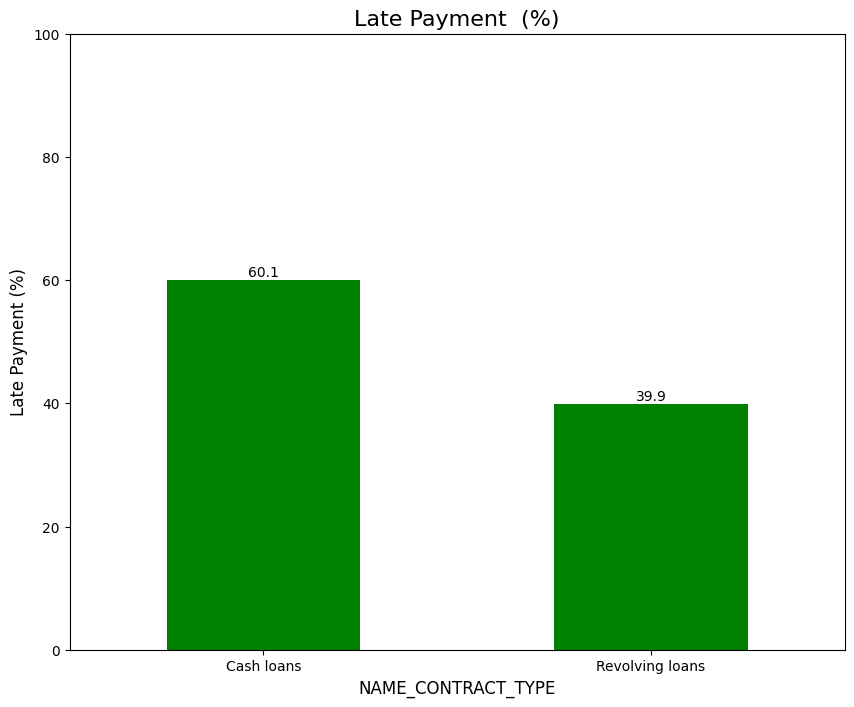

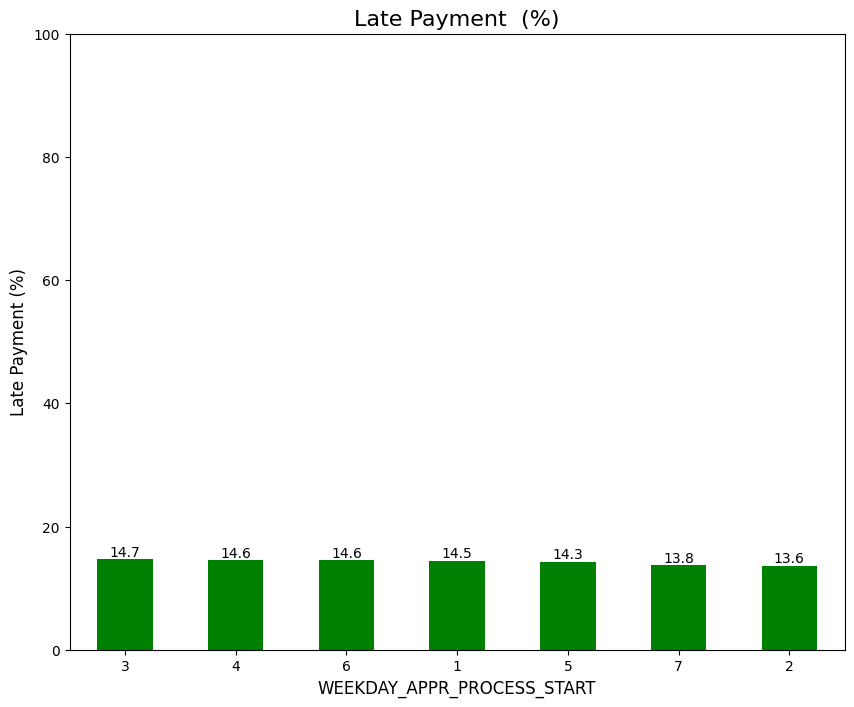

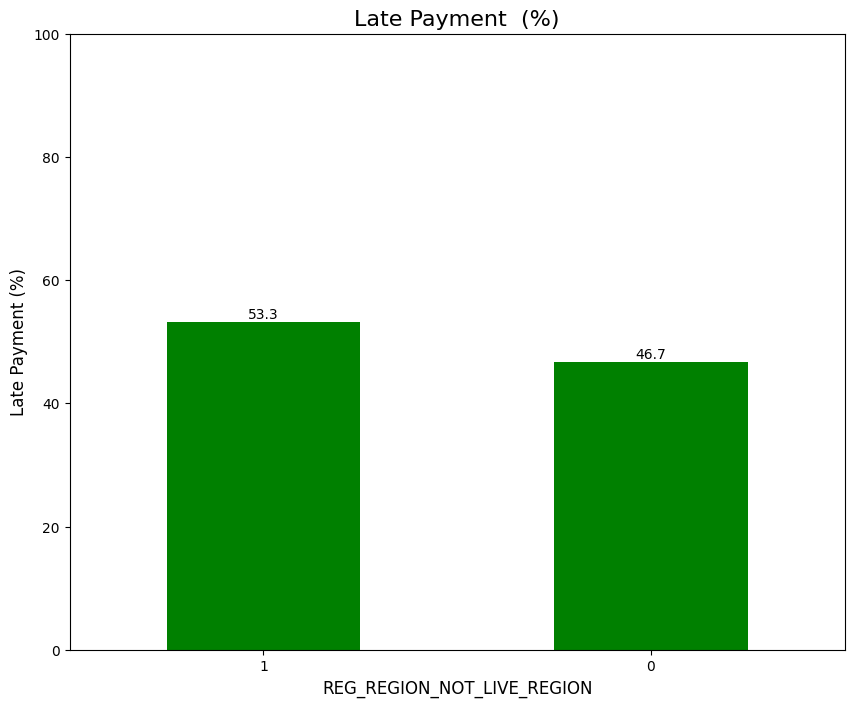

===== NAME_CONTRACT_TYPE =====
Number Expected :
[[191822.70077658  16845.29922342]
 [ 20186.29922342   1772.70077658]]

Chi-square Statistic : 208.3094505588519 ,p-value: 3.211461480492971e-47 kurang dari 0.05 
Variabel 1 dan Variabel 2 adalah variabel dependent

===== WEEKDAY_APPR_PROCESS_START =====
Number Expected :
[[11185.70467465   982.29532535]
 [35038.06161031  3076.93838969]
 [37104.5856166   3258.4143834 ]
 [35732.11215512  3137.88784488]
 [34683.22252382  3045.77747618]
 [34809.16282135  3056.83717865]
 [23456.15059815  2059.84940185]]

Chi-square Statistic : 16.4269406974669 ,p-value: 0.011636914027019904 kurang dari 0.05 
Variabel 1 dan Variabel 2 adalah variabel dependent

===== REG_REGION_NOT_LIVE_REGION =====
Number Expected :
[[208813.6096771  18337.3903229]
 [  3195.3903229    280.6096771]]

Chi-square Statistic : 5.650739900727603 ,p-value: 0.01744800868776273 kurang dari 0.05 
Variabel 1 dan Variabel 2 adalah variabel dependent



In [353]:
contract = ['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION']
for x in contract :
    predictor_target(x)
    
for x in contract :
    dataCek(x,'TARGET')

Customers who own motorised vehicles are more likely to experience late payments than customers who do not own motorised vehicles.

# **Data Preprocessing**

In [354]:
dataInfo(X_train)
X_train_drop = X_train.copy()
X_train_drop = X_train.drop(['WEEKDAY_APPR_PROCESS_START','FLAG_OWN_REALTY'],axis=1)
info_data(X_train_drop)

Number of Rows,Columns (230627, 13)
Number of Duplicated Values 1802
Number of Rows,Columns (230627, 11)
Number of Duplicated Values 13337


,Missing_value,Percent_missing_%,Data_type,Number of Unique
NAME_CONTRACT_TYPE,0,0.0,object,2
CODE_GENDER,0,0.0,object,2
FLAG_OWN_CAR,0,0.0,int64,2
CNT_CHILDREN,0,0.0,int64,14
AMT_INCOME_TOTAL,0,0.0,float64,2059
AMT_CREDIT,0,0.0,float64,5170
DAYS_BIRTH,0,0.0,float64,49
CNT_FAM_MEMBERS,0,0.0,float64,14
REGION_RATING_CLIENT,0,0.0,int64,3
REG_REGION_NOT_LIVE_REGION,0,0.0,int64,2


## **Convert Objects to Numeric - Training Data**

**One Hot Encoding**

Feature yang akan ditransform : NAME_CONTRACT_TYPE and CODE_GENDER	

In [355]:
X_train_drop= pd.get_dummies(X_train_drop,columns=['NAME_CONTRACT_TYPE'])
X_train_drop= pd.get_dummies(X_train_drop,columns=['CODE_GENDER'])

**Feature Selection**

In [356]:
X_train_drop = X_train_drop.drop('TARGET', axis=1)

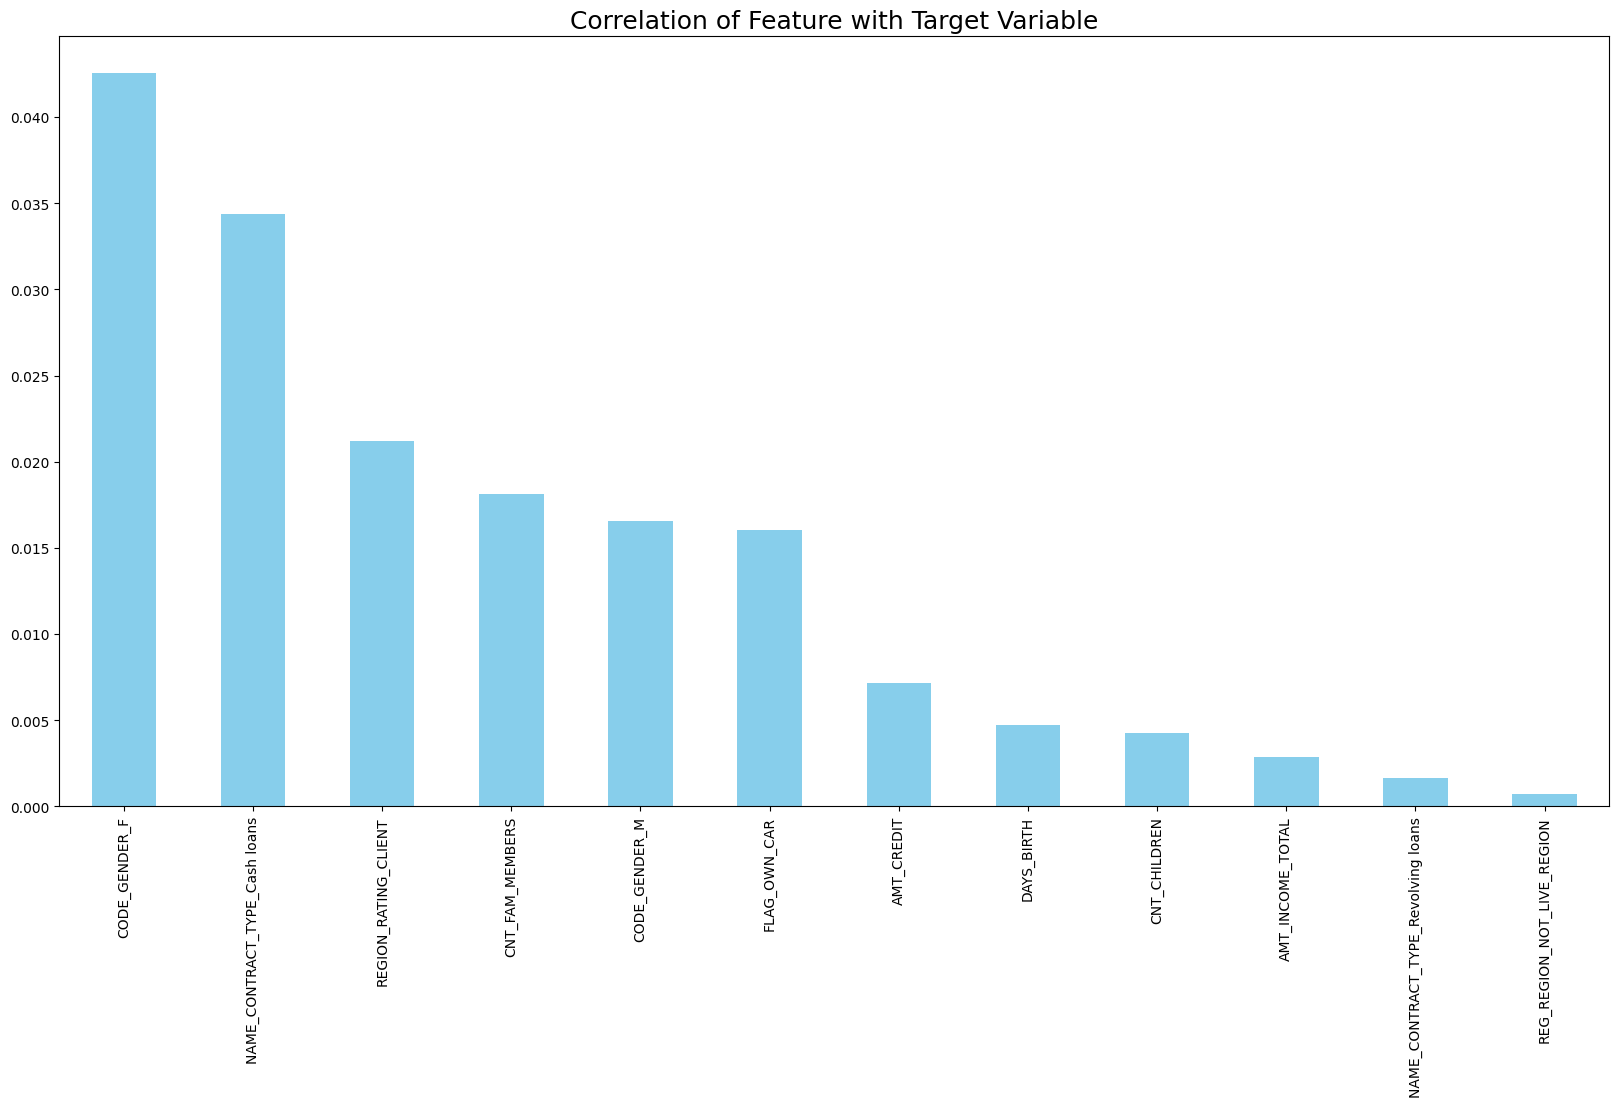

In [357]:
fsl = mutual_info_classif(X_train_drop, y_train, random_state=42)
mfsi = pd.Series(fsl, index=X_train_drop.columns)
mfsi.sort_values(ascending=False).plot(kind='bar', figsize=(20, 10), color='skyblue')
plt.title('Correlation of Feature with Target Variable', fontsize=18)
plt.show()


In [358]:
X_train_top10 = X_train_drop.drop(['NAME_CONTRACT_TYPE_Revolving loans','REG_REGION_NOT_LIVE_REGION'],axis=1)
X_train_top10.head()

,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_BIRTH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,NAME_CONTRACT_TYPE_Cash loans,CODE_GENDER_F,CODE_GENDER_M
115415,0,0,90000.0,161730.0,54.0,2.0,2,True,True,False
260031,0,1,112500.0,521280.0,28.0,3.0,3,True,True,False
128753,1,1,103500.0,315000.0,31.0,3.0,2,False,True,False
12997,0,0,135000.0,536917.5,62.0,2.0,2,True,True,False
166440,0,0,81000.0,350860.5,65.0,1.0,2,True,True,False


## **Testing Data**

In [359]:
for colname in ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    X_test[colname] = X_test[colname].map(yes_no_dict)
    
## One Hot Encoding
X_test = pd.get_dummies(X_test,columns=['NAME_CONTRACT_TYPE'])
X_test = pd.get_dummies(X_test,columns=['CODE_GENDER'])

X_test_top10 = X_test.copy()
X_test_top10 = X_test_top10[X_train_top10.columns]
X_test_top10.head()

,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_BIRTH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,NAME_CONTRACT_TYPE_Cash loans,CODE_GENDER_F,CODE_GENDER_M
229269,0,1,157500.0,592560.0,34.0,2.0,2,True,False,True
142049,1,0,211500.0,1100709.0,47.0,2.0,2,True,False,True
119753,1,2,126000.0,270000.0,40.0,4.0,2,False,True,False
259016,0,0,225000.0,343800.0,25.0,1.0,2,True,True,False
54373,0,0,112500.0,497520.0,50.0,2.0,2,True,False,True


**Feature Transformation**

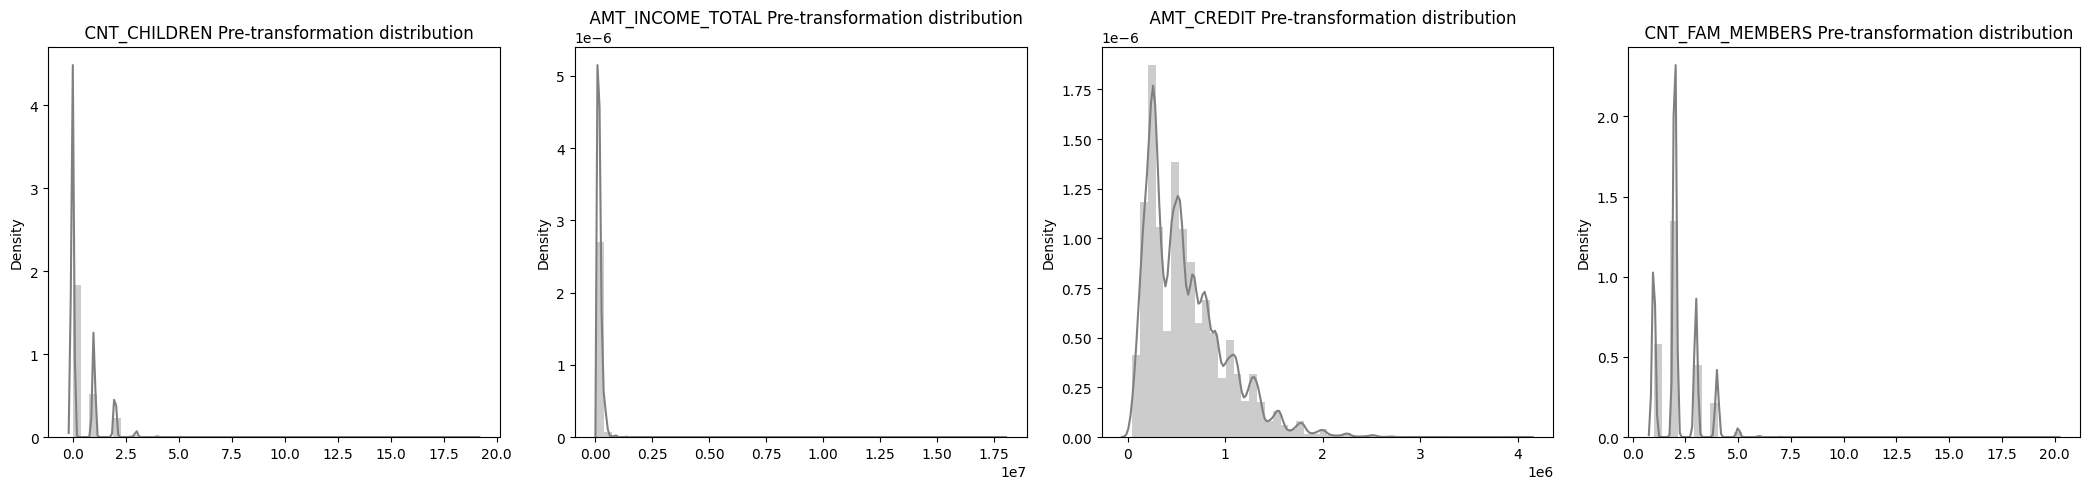

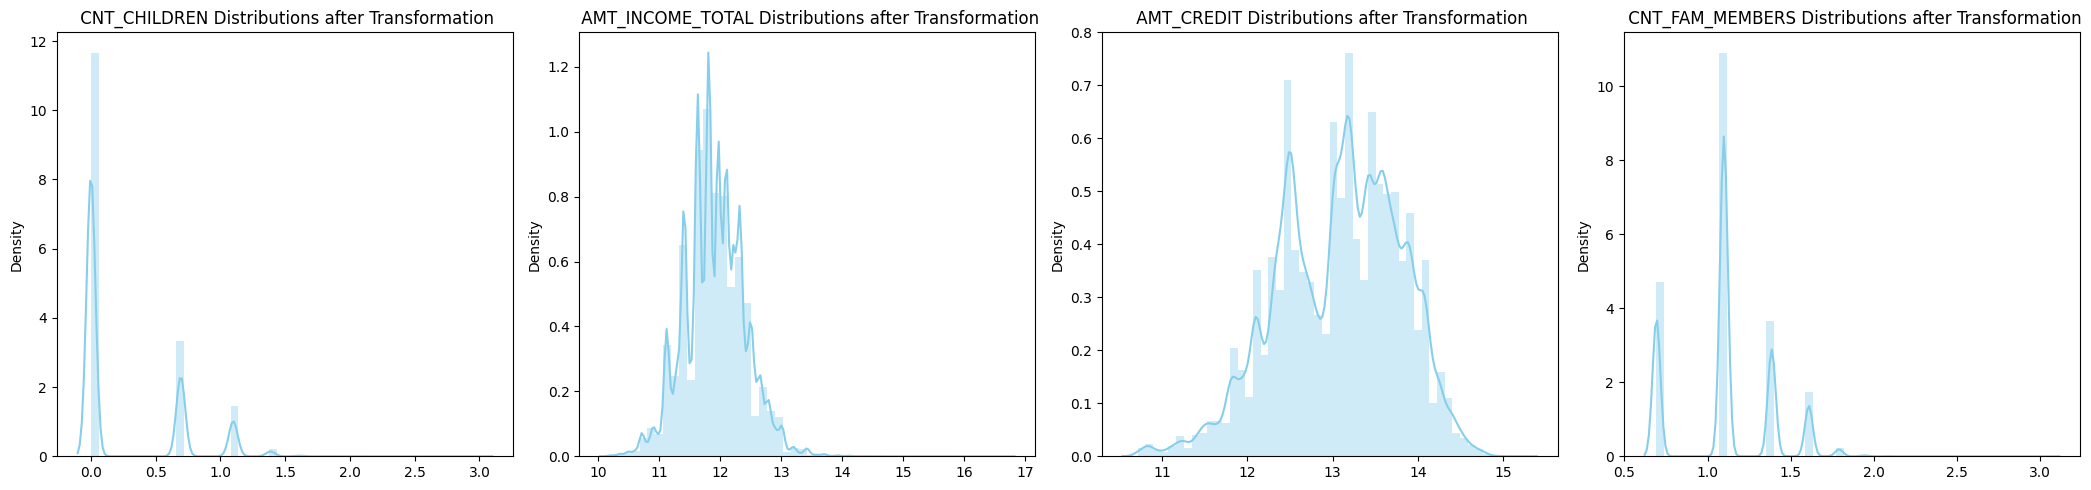

In [360]:
featureTransf = ['CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','CNT_FAM_MEMBERS']

plt.figure(figsize=(21,5))
for x in range(0, len(featureTransf)):
    plt.subplot(1, len(featureTransf), x+1)
    sns.distplot(x=X_train_top10[featureTransf[x]], color='grey')
    plt.title(f'  {featureTransf[x]} Pre-transformation distribution')
    plt.tight_layout()
    
plt.figure(figsize=(21,5))
for x in range(0, len(featureTransf)):
    plt.subplot(1, len(featureTransf), x+1)
    sns.distplot(x=np.log1p(X_train_top10[featureTransf[x]]), color='skyblue')
    plt.title(f' {featureTransf[x]} Distributions after Transformation')
    plt.tight_layout()

**Feature Scalling**

**- Data Training**

In [361]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
featureScall = ['FLAG_OWN_CAR','CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT', 'DAYS_BIRTH','CNT_FAM_MEMBERS','REGION_RATING_CLIENT']
X_train_top10[featureScall] = scaler.fit_transform(X_train_top10[featureScall])

**- Data Testing**

In [362]:
X_test_top10[featureScall] = scaler.fit_transform(X_test_top10[featureScall])
X_test_top10.head()

,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_BIRTH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,NAME_CONTRACT_TYPE_Cash loans,CODE_GENDER_F,CODE_GENDER_M
229269,-0.721193,0.816020,-0.107273,-0.010419,-0.830224,-0.164895,-0.102655,True,False,True
142049,1.386591,-0.572312,0.455235,1.256193,0.255098,-0.164895,-0.102655,True,False,True
119753,1.386591,2.204352,-0.435403,-0.814432,-0.329306,2.041083,-0.102655,False,True,False
259016,-0.721193,-0.572312,0.595862,-0.630479,-1.581601,-1.267884,-0.102655,True,True,False
54373,-0.721193,-0.572312,-0.576029,-0.247316,0.505557,-0.164895,-0.102655,True,False,True


## **Model,Evaluation, Feature Importance**

**1. KNN (K-Nearest Neighbors)**

In [363]:
km = KNeighborsClassifier()

 Recall Score : 0.06327210226662369
 Precision Score : 0.6259298618490967
 F1 Score : 0.11492682926829266
 ROC-AUC Score : 0.8899349512947734


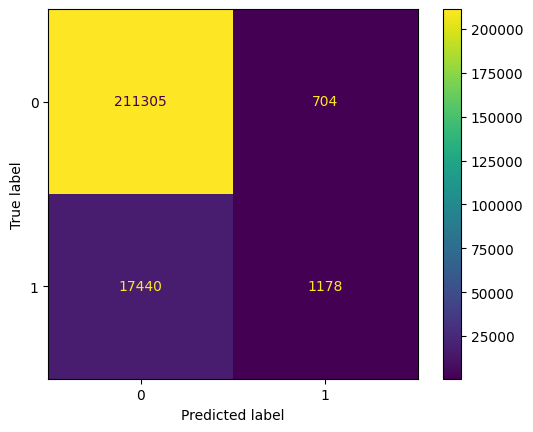

In [364]:
eval_train(X_train_top10,y_train,km)

 Recall Score : 0.015630035449564938
 Precision Score : 0.15594855305466238
 F1 Score : 0.02841241944932631
 ROC-AUC Score : 0.5425395406263426


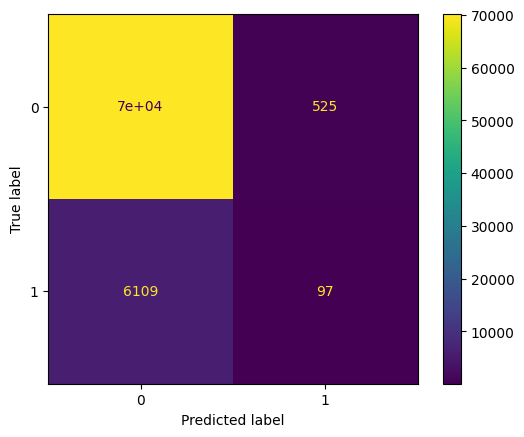

In [365]:
eval_test(X_test_top10,y_test,km)

### **2. Decision Tree**

In [366]:
dt = DecisionTreeClassifier(random_state=42)

 Recall Score : 0.9043398861317005
 Precision Score : 0.998103029225206
 F1 Score : 0.9489108687688449
 ROC-AUC Score : 0.9995353910019146


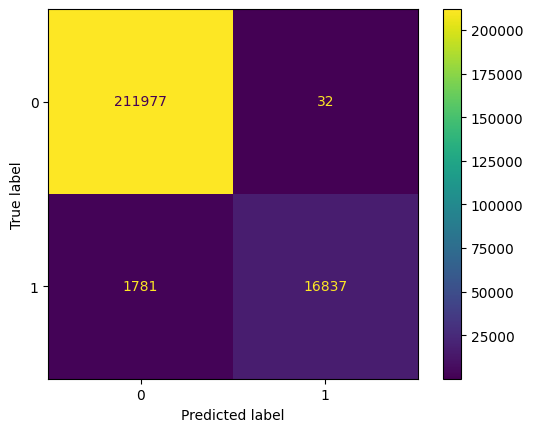

In [367]:
eval_train(X_train_top10,y_train,dt)

 Recall Score : 0.1308411214953271
 Precision Score : 0.1025123090518874
 F1 Score : 0.11495717420542224
 ROC-AUC Score : 0.5150865024498167


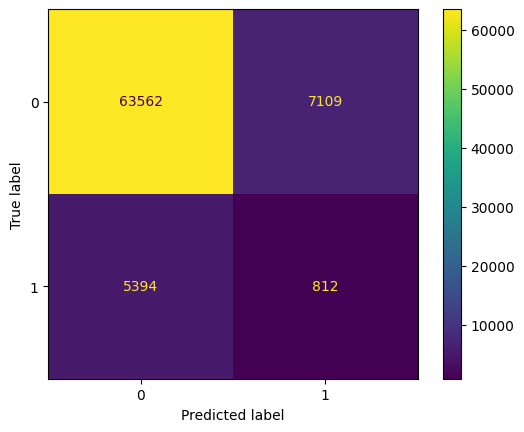

In [368]:
eval_test(X_test_top10,y_test,dt)

## **3. Naive Bayes**

In [369]:
nb = GaussianNB()

 Recall Score : 0.0045117628101836935
 Precision Score : 0.15412844036697249
 F1 Score : 0.008766894536346083
 ROC-AUC Score : 0.6173819328952707


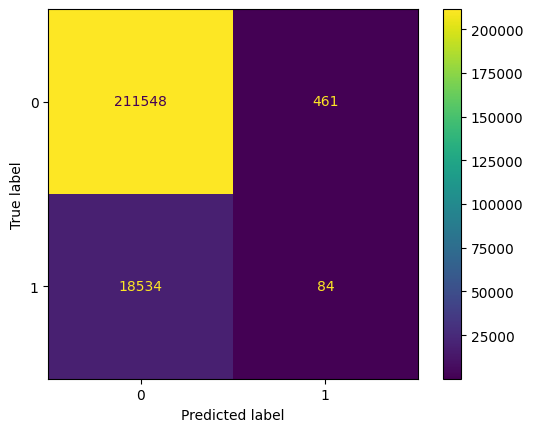

In [370]:
eval_train(X_train_top10,y_train,nb)

 Recall Score : 0.0045117628101836935
 Precision Score : 0.15412844036697249
 F1 Score : 0.008766894536346083
 ROC-AUC Score : 0.6173819328952707


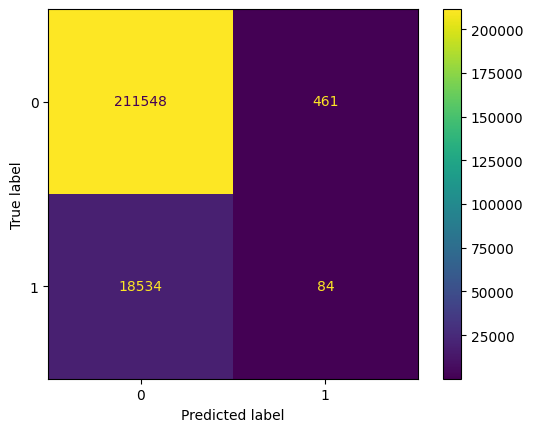

In [371]:
eval_test(X_train_top10,y_train,nb)

**Over Sampling**


In [372]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)
pd.Series(y_train).value_counts()

TARGET
0    212009
1     18618
Name: count, dtype: int64

In [373]:
X_train_smote,y_train_smote = smote.fit_resample(X_train_top10,y_train)
pd.Series(y_train_smote).value_counts()

TARGET
0    212009
1    106004
Name: count, dtype: int64

**Over Sampling Naive Bayes**

 Recall Score : 0.4414927738575903
 Precision Score : 0.4518464880521361
 F1 Score : 0.44660963169019796
 ROC-AUC Score : 0.6256346164070126


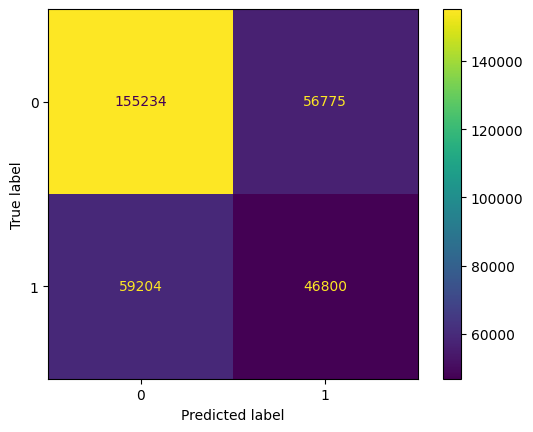

In [374]:
eval_train(X_train_smote,y_train_smote,nb)

 Recall Score : 0.40944247502417014
 Precision Score : 0.12432115074123


 F1 Score : 0.1907299680990805
 ROC-AUC Score : 0.6153152074374877


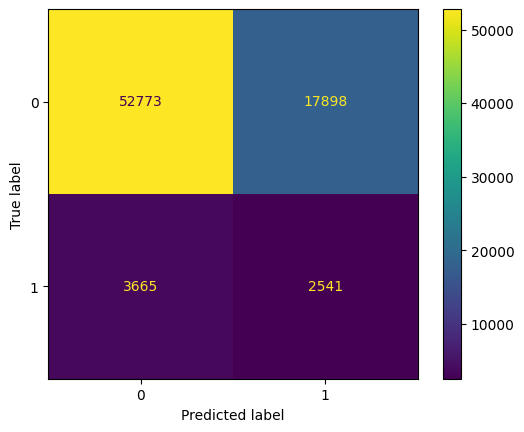

In [375]:
eval_test(X_test_top10,y_test,nb)

## ***Conclusion***

Classification models such as KNN, Decision Tree, and Naive Bayes were tested to predict the likelihood of late payments by customers. The following are the main findings:
1. KNN obtained the highest accuracy of 0.89, signalling its ability to distinguish customers who will and will not experience late payments.
2. Decision Tree had a slightly lower accuracy of 0.88, but was still able to distinguish the two groups of customers well.
3. Naive Bayes has the lowest accuracy, 0.87, but can still predict the likelihood of late payments.
   
Although Naive Bayes has a lower accuracy, the overall performance of the model is still good. Based on the analysis, there are some insights that can be used by companies:
- The feature is the main indicator to predict the probability of late payment. Companies can prioritise customers with low values to get loans.
- The amount of data in the class that will not experience late payments is much larger. Companies need to use oversampling or undersampling techniques to balance the amount of data in both classes.
  
Thus, Naive Bayes could be a suitable choice for this application. The insights gained can help the company in determining the distribution of loans to customers more precisely.